In [1]:
%load_ext autoreload

In [2]:
%matplotlib widget

# Imports

**General imports**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import fabio
import multiprocessing as mp
from tqdm.notebook import tqdm
from ipywidgets import IntSlider

**LaueTools imports**

In [4]:
from LaueTools.fit2Dintensity import gaussfit, twodgaussian
from LaueTools.IOLaueTools import readCalib_det_file
from LaueTools.dict_LaueTools import dict_CCD
from LaueTools.LaueGeometry import calc_uflab

In [ ]:
import laueutils

---
# Data location and metadata

In [14]:
data_folder = "path/to/data"
num_images  = 6561

In [11]:
scan_xsize,   scan_ysize   = 40, 40
scan_xpoints, scan_ypoints = 81, 81

**Scan points**

In [12]:
x, y = np.meshgrid(
    np.linspace(0, scan_xsize, scan_xpoints), 
    np.linspace(0, scan_ysize, scan_ypoints)
)

In [15]:
image_paths = [f"{data_folder}/img_{i:0>4d}.tif" for i in range(num_images)] # Modify

---

# Peaksearch on ROI

To get the ROI, stack all the images together, and then select the desired slice.

Here's an example

```python
def fetch_image(path):
    with fabio.open(path) as image:
        image_data = image.data
    return image_data

with mp.Pool(mp.cpu_count()) as pool:
    image_stack = pool.starmap(fetch_image, 
                               tqdm(zip(image_paths), 
                                    total=len(image_paths),
                                    desc=f'Loading scan'), 
                               chunksize=1)
image_stack = np.stack(image_stack)

ROIs = image_stack[:, 1304:1316, 1025:1037]
```

I already did it and saved the result. Let's load it.

In [18]:
ROIs = np.load("ROIs.npy")

In [19]:
ROI_shape  = ROIs[0].shape
ROI_coords = np.meshgrid(range(ROI_shape[0]), range(ROI_shape[1]))

**Visualize ROI**

IntSlider(value=0, max=6560)

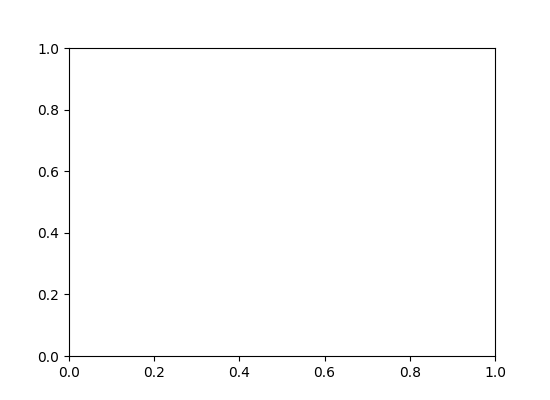

In [20]:
roi_slider = IntSlider(value=0, min=0, max=num_images-1, step=1)

ipyfig, ipyax = plt.subplots(figsize=(5.5,4))

def plot_roi(slider):
    ipyax.cla()
    selected_image  = ROIs[slider.new]
    fit_params_temp = gaussfit(selected_image)
    I_values_temp   = twodgaussian(fit_params_temp, circle=0, rotate=1, vheight=1)(*ROI_coords)
    
    image = ipyax.imshow(selected_image, vmin=1000, vmax=10000, cmap='gray')
    ipyax.contour(I_values_temp, vmin=1000, vmax=10000, cmap='Greens')
    laueutils.visualization.draw_colorbar(image)
    ipyax.set_title(f"Image {slider.new}")

roi_slider.observe(plot_roi, 'value')
display(roi_slider)

**Fit all of them**

In [21]:
fit_params = []
for roi in tqdm(ROIs, total=len(ROIs)):
    fit_params.append(gaussfit(roi))
fit_params = np.vstack(fit_params)

# I just want the deviations from the average position
x_position = fit_params[:,2] - fit_params[:,2].mean()
y_position = fit_params[:,3] - fit_params[:,3].mean()

  0%|          | 0/6561 [00:00<?, ?it/s]

**Visualize the fit**

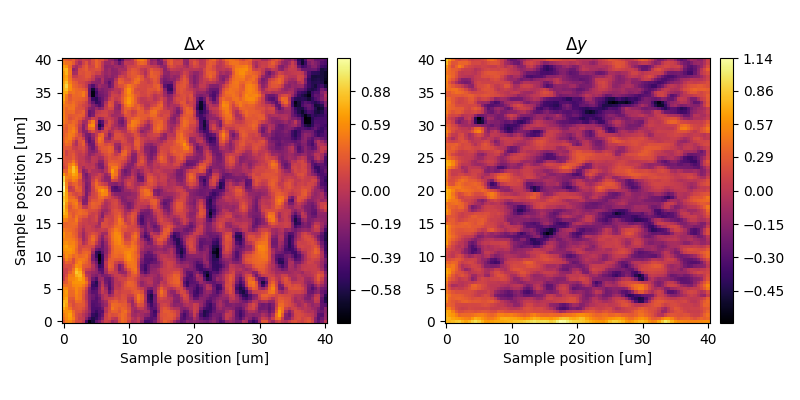

In [26]:
# Sample position coordinates
x, y = np.meshgrid(np.linspace(0,40,81), np.linspace(0,40,81))

fig, axes = plt.subplots(1,2, figsize=(8,4))
for ax, data in zip(axes, (x_position, y_position)):
    # Colorbar centered around 0
    norm, cbar_ticks = laueutils.visualization.cbarticks_zero_centered(data.min(), data.max())
    image = ax.pcolormesh(x,y,data.reshape(81,81), cmap='inferno', norm=norm)
    laueutils.visualization.draw_colorbar(image, ticks=np.round(cbar_ticks,2))
    ax.set_aspect('equal')
    ax.set_xlabel('Sample position [um]')
    
axes[0].set_ylabel('Sample position [um]')
axes[0].set_title(r'$\Delta x$')
axes[1].set_title(r'$\Delta y$')
fig.tight_layout()

# Scattering angles

## Detector calibration

At this point you might want to read the calibration file with something like

```python
calibration_dictionary = readCalib_det_file("path/to/calibration.det")
calibration_parameters = dict_calib["CCDCalibParameters"]
pixel_size = dict_calib["pixelsize"]

for key, value in calibration_dictionary.items():
    print(f"{key: >18}: {value}")
```

Here I input manually the entries of the dictionary

In [30]:
calibration_dictionary = {
                "dd": 83.261,
              "xcen": 1053.24,
              "ycen": 1128.22,
              "xbet": -0.162,
              "xgam": 0.295,
         "pixelsize": 0.0734,
        "xpixelsize": 0.0734,
        "ypixelsize": 0.0734,
          "CCDLabel": "sCMOS",
          "framedim": [2018., 2016.],
  "detectordiameter": 148.1212,
      "kf_direction": "Z>0",
          "UB_calib": [0.4125557,  0.6343861, -0.6537218, -0.8326232,  0.5537125,  0.0118768, 0.3695084,  0.5394041,  0.7566418],
"CCDCalibParameters": [83.261, 1053.24, 1128.22, -0.162, 0.295]
}

In [36]:
print(
    "Calibration parameters\n\n", 
    calibration_parameters := calibration_dictionary["CCDCalibParameters"],
    "\n\nPixel size\n\n",
    pixelsize := calibration_dictionary["pixelsize"], "[mm]" 
)

Calibration parameters

 [83.261, 1053.24, 1128.22, -0.162, 0.295] 

Pixel size

 0.0734 [mm]


## Computation
The actual computation of the angles happens here

In [51]:
twotheta, chi = calc_uflab(x_position, y_position, calibration_parameters, pixelsize=pixelsize)

In [52]:
# Compute the differences
delta_twotheta = twotheta - twotheta.mean()
delta_chi      = chi - chi.mean()

## Save to file

In [53]:
peak_properties = np.concatenate((fit_params, delta_twotheta.reshape(-1,1), delta_chi.reshape(-1,1)), axis = 1)

In [49]:
# Formatting shenanigans
# ----------------------------------------------------------------------------------------------------------------
title   = "Mysterious pattern central peak parameters\n"
columns = ["I_baseline",  "Intensity", "Δxcam", "Δycam", "FWHM_maj", "FWHM_min", "orientation", "Δ2theta", "Δchi"]
units   = ["[cts]", "[cts]", "[pix]", "[pix]", "[pix]", "[pix]", "[deg]", "[deg]", "[deg]"]
digits  = [2, 2, 3, 3, 3, 3, 2, 5, 5 ] # How many decimal digits to keep

column_widths = [max(len(column), digit+3) for column, digit in zip(columns, digits)]

# format header
header  = title + " ".join([f"{column: >{width}}" for column, width in zip(columns, column_widths)]) # pad column names
header += "\n"  + " ".join([f"{  unit: >{width}}" for   unit, width in zip(  units, column_widths)]) # pad units
# format numbers
fmt    = [f"%{width}.{digit}f" for width, digit in zip(column_widths, digits)]
# shift initial formatter by two characters to account for "# " at the beginning of headers
fmt[0] = f"%{column_widths[0]+2}.{digits[0]}f"
# ----------------------------------------------------------------------------------------------------------------

# Actual saving
np.savetxt("ROIs_fit_properties.txt", peak_properties, fmt=fmt, header=header)

# Visualization

If you want to start directly from this point, you may load the data generated from the previous cell.

```python
peak_properties = np.loadtxt("ROIs_fit_properties.txt")
```

## Deviation in scattering angles

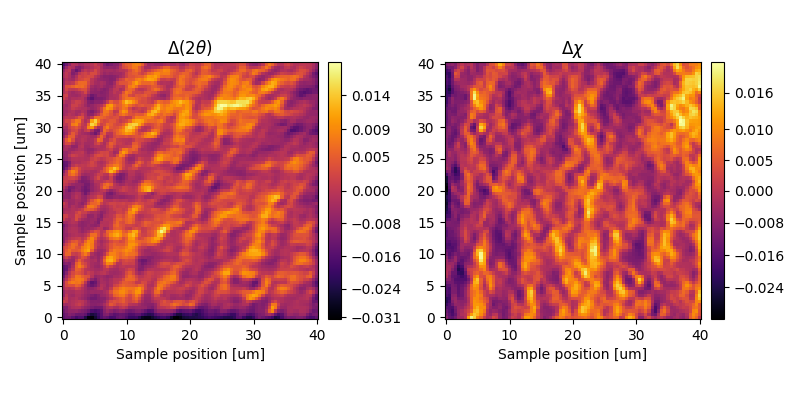

In [57]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
for ax, data in zip(axes, (delta_twotheta, delta_chi)):
    # Colorbar centered around 0
    norm, cbar_ticks = laueutils.visualization.cbarticks_zero_centered(data.min(), data.max())
    image = ax.pcolormesh(x, y, data.reshape(81,81), cmap='inferno', norm=norm)
    laueutils.visualization.draw_colorbar(image, ticks=np.round(cbar_ticks,3))
    ax.set_aspect('equal')
    ax.set_xlabel('Sample position [um]')

axes[0].set_ylabel('Sample position [um]')
axes[0].set_title(r'$\Delta(2\theta)$')
axes[1].set_title(r'$\Delta\chi$')
fig.tight_layout()

## Histogram

In [58]:
from scipy.optimize import curve_fit

In [59]:
def _gaussian(x, A, MEAN, FWHM):
    sigma = FWHM/(2*np.sqrt(2*np.log(2)))
    return A * np.exp(- (x - MEAN)**2 / (2 * sigma**2))

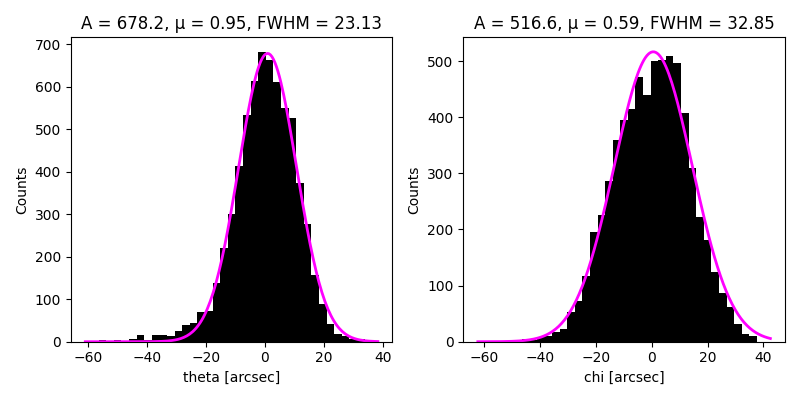

In [61]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
for ax, data in zip(axes, (delta_twotheta*1800, delta_chi*1800)):
    counts, bins, image = ax.hist(data, bins=35, color='black')
    
    # Fitting
    bin_centers = bins[:-1] + np.diff(bins)/2
    p, _ = curve_fit(_gaussian, bin_centers, counts, p0 = (500, 0, 10))
    xlims = ax.get_xlim()
    xvals = np.linspace(xlims[0], xlims[1], 200)
    ax.plot(xvals, _gaussian(xvals, *p), color = 'magenta', linewidth = 2)
    ax.set_title(f'A = {p[0]:.1f}, μ = {p[1]:.2f}, FWHM = {p[2]:.2f}')
    ax.set_ylabel('Counts')


axes[0].set_xlabel("theta [arcsec]")
axes[1].set_xlabel("chi [arcsec]")
fig.tight_layout()